## Hospital Readmission Prediction

In [3]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

Loading the data set 


In [4]:
data = pd.read_csv('diabetic_data.csv')

In [13]:
data.shape

(101766, 50)

In [14]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


The main outcome is whether the patient is readmitted or not within the 30 days of sicharge.
Let us describe thte readmitted column

In [15]:
data.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

And from the id _mappings.csv file we can see that the discharge_disposition_id with the numbers 11,13,14,19,20,21 
are related to death or hospice. 
We need to discard these row from the data set since they are never again going to be readmitted.


In [16]:
data = data.loc[~data.discharge_disposition_id.isin([11,13,14,19,20,21])]

In [17]:
data.shape

(99343, 50)

Now we are convering it into a binary classification task by renaming the outcomes 
Now 1 is encoded as Readmitted within 30 days.
Rest 0 is encoded as nort readmitted within 30 days.

In [18]:
data['OUTCOME'] = (data.readmitted == '<30').astype('int')

Lets calculate the distribution of the outcome by knowing the no of patients/ in readmitted class

In [51]:
def calc_proportion(y):
    return (sum(y)/len(y))
print('Prevalence:%.3f'%calc_proportion(data['OUTCOME'].values))

Prevalence:0.114


Around 11% of the population is rehospitalized. This represented an imbalanced classification problem so we will address that below.

Now ,lets examine the other feauters of the dataset to see if they need any transformations.

In [19]:
# for each list we are now going to print the number of unique values of each column.
for col in list(data.columns):   
    # get a list of unique values
    no = data[col].unique()  
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(no)<30:
        print(col)
        print(no)
    else:
        print(col + ': ' +str(len(no)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 

#FEATURE EXPLORATION / FEATURE ENGINEERING

There are 2 types of variable namely numerical values and categorical values in all these columns of the dataset.

In [20]:
col_nm=data.columns.values 

In [21]:
#checking for missing numbers 
data[col_nm].isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

Inorder to fit the data into the model, the data has to be numeric . So, we need to convert the categorical features into numeric 
Here we shall use one hot encoding to do so.

In [22]:
num_cols=['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

cat_cols=['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

Let's investigate medical specialty before we begin.



In [23]:
print('Number medical specialty:', data.medical_specialty.nunique())
data.groupby('medical_specialty').size().sort_values(ascending = False)


Number medical specialty: 73


medical_specialty
?                                    48616
InternalMedicine                     14237
Emergency/Trauma                      7419
Family/GeneralPractice                7252
Cardiology                            5279
Surgery-General                       3059
Nephrology                            1539
Orthopedics                           1392
Orthopedics-Reconstructive            1230
Radiologist                           1121
Pulmonology                            854
Psychiatry                             853
Urology                                682
ObstetricsandGynecology                669
Surgery-Cardiovascular/Thoracic        642
Gastroenterology                       538
Surgery-Vascular                       525
Surgery-Neuro                          462
PhysicalMedicineandRehabilitation      391
Oncology                               319
Pediatrics                             253
Neurology                              201
Hematology/Oncology                 

Since we cannot create 73 different columns we just consider the top 10 categories of this column and
replace all other s into a column Other


In [24]:
data.shape

(99343, 51)

In [25]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
data['med_spec'] = data['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
data.loc[~data.med_spec.isin(top_10),'med_spec'] = 'Other'

In [26]:
data.shape

(99343, 52)

In [27]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

data[cols_cat_num] = data[cols_cat_num].astype('str')

In [28]:
data.shape


(99343, 52)

Here we are creating one hot encoding for all categorical columns 

In [29]:
df_cat = pd.get_dummies(data[cat_cols + cols_cat_num + ['med_spec']],drop_first = True)

In [30]:
df_cat.shape


(99343, 132)

(99343, 52)

In [31]:
cols_all_cat = list(df_cat.columns)

Now age,weight have different number attributes and lets convert them


In [32]:
data[['age', 'weight']].head()

,age,weight
0,[0-10),?
1,[10-20),?
2,[20-30),?
3,[30-40),?
4,[40-50),?


In [33]:
data.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

In [34]:
#Let's map these to 0-9 for the numerical data.

age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
data['age_group'] = data.age.replace(age_id)
cols_extra=['age_group']

In [35]:
#print('Total number of features:', len(num_cols+ cols_all_cat + cols_extra))
print('Numerical Features:',len(num_cols))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Numerical Features: 8
Categorical Features: 132
Extra features: 1


In [36]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,OUTCOME,med_spec,age_group
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,0,Other,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,0,Other,10
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,0,Other,20
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,0,Other,30
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,0,Other,40


In [37]:
col2use = num_cols + cols_all_cat + cols_extra +['OUTCOME']
col_without_outcome=num_cols + cols_all_cat + cols_extra

In [40]:
#len(col2use)


NameError: name 'df_add' is not defined

In [41]:

df_add=pd.concat([data,df_cat],axis=1)

#df_data = df_cat[col2use]

In [42]:
df_add[num_cols + cols_all_cat].shape

(99343, 140)

In [43]:
data[num_cols].shape

(99343, 8)

In [44]:
df_f=pd.concat([df_add[num_cols + cols_all_cat],data['age_group'],data['OUTCOME']],axis=1)

In [45]:
df=pd.DataFrame(df_f)

In [46]:
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,age_group,OUTCOME
0,1,41,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,3,59,0,18,0,0,0,9,0,0,...,0,0,0,0,0,1,0,0,10,0
2,2,11,5,13,2,0,1,6,1,0,...,0,0,0,0,0,1,0,0,20,0
3,2,44,1,16,0,0,0,7,0,0,...,0,0,0,0,0,1,0,0,30,0
4,1,51,0,8,0,0,0,5,0,0,...,0,0,0,0,0,1,0,0,40,0


In [47]:
# write the preprocessed data to csv
df.to_csv('./processed.csv', sep='\t', encoding='utf-8')





##Building Training/Validation/Test Samples

Inorder to fit the above procesed data into our machine learning algorithms and make futher predictions we nedd to divide the data set into 
traint test and validation samples.

In this project, we will split into 70% train, 15% validation, 15% test.

In [48]:
#shuffle the sample
# shuffle the samples
df_data = df.sample(n = len(df), random_state = 42)
df_data = df.reset_index(drop = True)

Now we can split the dataset into train/test/validation

In [49]:
#sample the whole dataset into train/validation first 
df_valid_test=df_data.sample(frac=0.30,random_state=42)


#dividing the test  and validation with 1:1 ratio
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)


# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

next we calculate the proportions of each outcome label in each of these data sets to check for class balance 

In [52]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_proportion(df_test.OUTCOME.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_proportion(df_valid.OUTCOME.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_proportion(df_train_all.OUTCOME.values)))

Test prevalence(n = 14902):0.116
Valid prevalence(n = 14901):0.115
Train all prevalence(n = 69540):0.113


As we can see the data has a higher imbalnce with the readmmision rate is only 11% in all the data samples.
In order tho overcome this imbalance we  can build a balanced dataset by making the proportion of 2 outcomes equal.
We can do this by sampling the nonreadmissions = no of readmissions



In [53]:
rows_pos = df_train_all.OUTCOME == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_proportion(df_train.OUTCOME.values)))

Train balanced prevalence(n = 15746):0.500


In [54]:

#let us save all the dataets build
df_train_all.to_csv('./df_train_all.csv',index=False)
df_train.to_csv('./df_train.csv',index=False)
df_valid.to_csv('./df_valid.csv',index=False)
df_test.to_csv('./df_test.csv',index=False)

In [55]:
X_train = df_train[col_without_outcome].values
X_train_all = df_train_all[col_without_outcome].values
X_valid = df_valid[col_without_outcome].values

y_train = df_train['OUTCOME'].values
y_valid = df_valid['OUTCOME'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 141)
Training shapes: (15746, 141) (15746,)
Validation shapes: (14901, 141) (14901,)


In [112]:
#scaling all the data 
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)


/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [113]:
#saving to a pickle file
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [114]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [115]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
#modellin gthe data 

In [60]:

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_proportion(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [61]:
thresh = 0.5

#models
K-nearest neighbors 

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

# k-nearest neighbours 

In [63]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


KNN
Training:
AUC:0.646
accuracy:0.597
recall:0.469
precision:0.631
specificity:0.674
prevalence:0.500
 
Validation:
AUC:0.620
accuracy:0.686
recall:0.454
precision:0.171
specificity:0.664
prevalence:0.115
 


# logistic Regression 

In [64]:




from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)


Logistic Regression
Training:
AUC:0.671
accuracy:0.619
recall:0.545
precision:0.640
specificity:0.694
prevalence:0.500
 
Validation:
AUC:0.651
accuracy:0.669
recall:0.524
precision:0.179
specificity:0.688
prevalence:0.115
 


# Stochastic Gradient Descent

In [66]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [67]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.668
accuracy:0.620
recall:0.542
precision:0.642
specificity:0.697
prevalence:0.500
 
Validation:
AUC:0.652
accuracy:0.671
recall:0.514
precision:0.178
specificity:0.692
prevalence:0.115
 


# Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [69]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.734
accuracy:0.669
recall:0.655
precision:0.674
specificity:0.681
prevalence:0.500
 
Validation:
AUC:0.618
accuracy:0.615
recall:0.582
precision:0.165
specificity:0.618
prevalence:0.115
 


# Naive Bayes

In [77]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB(priors=None)

In [78]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.513
accuracy:0.503
recall:0.992
precision:0.502
specificity:0.014
prevalence:0.500
 
Validation:
AUC:0.511
accuracy:0.123
recall:0.993
precision:0.115
specificity:0.011
prevalence:0.115
 


# Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [72]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.678
accuracy:0.630
recall:0.581
precision:0.644
specificity:0.679
prevalence:0.500
 
Validation:
AUC:0.644
accuracy:0.649
recall:0.571
precision:0.179
specificity:0.659
prevalence:0.115
 


# Gradient Boosting Classifier

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [74]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.774
accuracy:0.697
recall:0.674
precision:0.707
specificity:0.720
prevalence:0.500
 
Validation:
AUC:0.624
accuracy:0.619
recall:0.562
precision:0.163
specificity:0.626
prevalence:0.115
 


# Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn. In this project, we will utilize the Area under the ROC curve (AUC) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold.

In [79]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

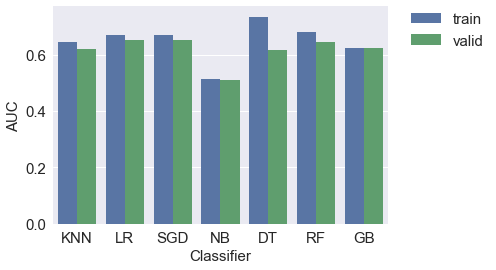

In [81]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

# Hyper Parameter Tuning

Hyperparameter tuning are essentially the design decisions that you made when you set up the machine learning model.

In [85]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [86]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(1,10,1)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [87]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [88]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, scoring=auc_scoring,
                               verbose = 1, random_state = 42)

In [90]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.0min finished


123.04651021957397


In [91]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 4,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'entropy'}

In [92]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.678
Validation AUC:0.644
Optimized Random Forest
Training AUC:0.720
Validation AUC:0.660


Optimize- stochastic gradient descent

In [93]:
penalty = ['none','l2','l1']
max_iter = range(100,500,100)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, 
                                 n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, 
                                 random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

65.35107779502869


In [94]:
sgdc_random.best_params_

{'penalty': 'l2', 'max_iter': 100, 'alpha': 0.1}

In [95]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Baseline sgdc')
sgdc_train_auc_base = roc_auc_score(y_train, y_train_preds)
sgdc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(sgdc_train_auc_base))
print('Validation AUC:%.3f'%(sgdc_valid_auc_base))
print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_auc))
print('Validation AUC:%.3f'%(sgdc_valid_auc))

Baseline sgdc
Training AUC:0.668
Validation AUC:0.652
Optimized sgdc
Training AUC:0.669
Validation AUC:0.653


 Optimize gradient boosting classifier

In [96]:
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, scoring=auc_scoring,
                                verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

310.86262583732605


In [97]:
gbc_random.best_params_

{'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1}

In [98]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.774
Validation AUC:0.624
Optimized gbc
Training AUC:0.684
Validation AUC:0.663


# Hyperparameter tuning results

In [99]:
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF','GB','GB'],
                           'data_set':['base','optimized']*3,
                          'auc':[sgdc_valid_auc_base,sgdc_valid_auc,
                                 rf_valid_auc_base,rf_valid_auc,
                                 gbc_valid_auc_base,gbc_valid_auc,],
                          })

In [100]:
df_results

,auc,classifier,data_set
0,0.652060,SGD,base
1,0.652774,SGD,optimized
2,0.644446,RF,base
3,0.659661,RF,optimized
4,0.624083,GB,base
5,0.663149,GB,optimized


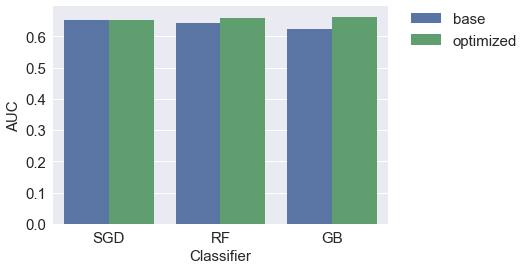

In [101]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

In [ ]:
# Model Selection: Best Classifier- Random Forest 

In [102]:
pickle.dump(rf_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

In [ ]:
# Model Evaluation

In [147]:
X_test = df_test[col2use].values
y_test = df_test['OUTCOME'].values
scaler  = StandardScaler()
scaler.fit(X_train)
X_test_df=pd.DataFrame(X_test)
X_test_rf=X_test_df.iloc[:,0:141]
#scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test_rf)

/Users/manaswithachimakurthi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [149]:
X_test_tf = scaler.transform(X_test_rf)

In [150]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [151]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [152]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.720
accuracy:0.655
recall:0.623
precision:0.665
specificity:0.687
prevalence:0.500
 
Validation:
AUC:0.660
accuracy:0.643
recall:0.585
precision:0.178
specificity:0.650
prevalence:0.115
 
Test:
AUC:0.662
accuracy:0.652
recall:0.575
precision:0.183
specificity:0.663
prevalence:0.116
 


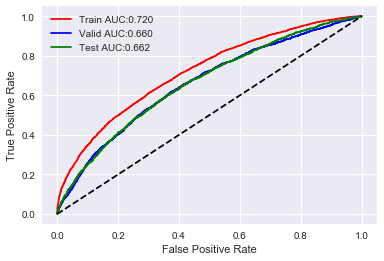

In [153]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()